In [ ]:
import random
import numpy as np
import pandas as pd
from scipy.stats import johnsonsu, lognorm, fisk, gamma, t
import matplotlib.pyplot as plt

# Constants
NUM_BOOK_TYPES = 3
SIMULATION_DAYS = 5000
WEEKDAYS = [0, 1, 2, 3, 4]  # Monday to Friday (0=Monday)
ITERATIONS = 20  # Number of independent simulations
REDIRECT_PROB_MEAN = 0.1  # Mean probability of redirection
REDIRECT_PROB_VAR = 0.05  # Variance of redirection probability

# Parameters for Book Types
johnsonsu_params = (-5.412009795166383, 1.2158269960642396, -0.6442993759442319, 0.08848608166937053)
lognorm_params = (0.1656956836459968, -27.963582289149212, 45.16307141247669)
fisk_params = (1.7006491394342107, -0.28853320615226913, 2.356547479289439)
gamma_params = (5.555446437445503, 1.4562352649119112, 2.533221426425163)
johnsonsu_params_bt3 = (-5.580412898464843, 0.9277379891052998, -0.39322457862293647, 0.01623231780865644)
fisk_params_bt3 = (2.0321905831010936, 4.467234342314011, 8.768907777431258)

# Truncated Random Variable Generation

def truncate_rv(distribution, params, lower, upper, size=1):
    """Generate truncated random variables for a given distribution."""
    cdf_lower = distribution.cdf(lower, *params)
    cdf_upper = distribution.cdf(upper, *params)

    def truncated_sampler():
        while True:
            sample = distribution.rvs(*params, size=1)[0]
            cdf_sample = distribution.cdf(sample, *params)
            if cdf_lower <= cdf_sample <= cdf_upper:
                return sample

    return np.array([truncated_sampler() for _ in range(size)])

# Functions to generate random variables for loan and return rates

def generate_loan_rate(book_type):
    if book_type == 1:
        return johnsonsu.rvs(*johnsonsu_params, size=1)[0]
    elif book_type == 2:
        return fisk.rvs(*fisk_params, size=1)[0]
    elif book_type == 3:
        return johnsonsu.rvs(*johnsonsu_params_bt3, size=1)[0]

def generate_return_rate(book_type, truncation_range):
    lower, upper = truncation_range
    if book_type == 1:
        return truncate_rv(lognorm, lognorm_params, lower, upper, size=1)[0]
    elif book_type == 2:
        return truncate_rv(gamma, gamma_params, lower, upper, size=1)[0]
    elif book_type == 3:
        return truncate_rv(fisk, fisk_params_bt3, lower, upper, size=1)[0]

# Simulate Policy with Scenario Parameters and Redirection

def simulate_book_type(book_type, max_loan_period, truncation_ranges, max_queue_lengths, books_per_type, seed):
    results = []
    for truncation_range in truncation_ranges:
        for max_queue_length in max_queue_lengths:
            random.seed(seed)
            np.random.seed(seed)

            books = {
                copy_id: {"next_available": 0, "loaned_time": 0, "total_delay": 0}
                for copy_id in range(1, books_per_type + 1)
            }

            queue = []
            blocks = 0
            total_requests = 0

            blocking_probabilities = []
            utilities = []
            average_delays = []

            all_delays_by_type = []  # Track all delays

            for day in range(SIMULATION_DAYS):
                if day % 7 not in WEEKDAYS:  # Skip weekends
                    continue

                daily_blocks = 0
                daily_requests = 0
                daily_loaned_time = 0

                for copy_id, book_data in books.items():
                    loan_rate = generate_loan_rate(book_type)
                    if random.random() < loan_rate:  # Loan request
                        daily_requests += 1

                        if book_data["next_available"] <= day:  # Book is available
                            return_duration = min(int(generate_return_rate(book_type, truncation_range)), max_loan_period)
                            return_time = day + return_duration
                            delay = max(0, day - book_data["next_available"])
                            book_data["total_delay"] += delay
                            book_data["next_available"] = return_time
                            book_data["loaned_time"] += return_duration
                            daily_loaned_time += return_duration
                        else:  # Book is not available
                            if len(queue) < max_queue_length:  # Add to queue
                                queue.append(day)
                            else:  # Queue full, attempt redirection
                                redirect_prob = max(0, min(1, np.random.normal(REDIRECT_PROB_MEAN, REDIRECT_PROB_VAR)))
                                if random.random() < redirect_prob:  # Attempt to redirect
                                    daily_blocks += 1
                                else:  # Block without redirection
                                    daily_blocks += 1

                blocks += daily_blocks
                total_requests += daily_requests

                blocking_probabilities.append(blocks / total_requests if total_requests > 0 else 0)
                utilities.append(len([1 for book_data in books.values() if book_data['next_available'] > day]) / books_per_type)

                # Update delays for all served customers
                for copy_id, book_data in books.items():
                    if book_data["next_available"] > day:
                        delay = max(0, book_data["next_available"] - day)
                        all_delays_by_type.append(delay)

                total_delay = sum(all_delays_by_type) / len(all_delays_by_type) if all_delays_by_type else 0
                average_delays.append(total_delay)

            results.append({
                "Return Range": f"{truncation_range}",
                "Queue Length": max_queue_length,
                "Books Per Type": books_per_type,
                "Blocking Probability": blocking_probabilities,
                "Utility": utilities,
                "Average Delay": average_delays,
                "Avg Blocking Probability": np.mean(blocking_probabilities),
                "Var Blocking Probability": np.var(blocking_probabilities),
                "Avg Utility": np.mean(utilities),
                "Var Utility": np.var(utilities),
                "Avg Average Delay": np.mean(average_delays),
                "Var Average Delay": np.var(average_delays)
            })

    return pd.DataFrame(results)



In [ ]:
# Test a Book Type
book_type_to_test = 1
truncation_ranges = [(0, np.inf), (0, 14), (0, 21)]
max_queue_lengths = [3, 5]
books_per_type = 10
seed = 42

results_df = simulate_book_type(book_type_to_test, 14, truncation_ranges, max_queue_lengths, books_per_type, seed)

In [ ]:
results_df

,Return Range,Queue Length,Books Per Type,Blocking Probability,Utility,Average Delay,Avg Blocking Probability,Var Blocking Probability,Avg Utility,Var Utility,Avg Average Delay,Var Average Delay
0,"(0, inf)",3,10,"[0.0, 0.2777777777777778, 0.5, 0.6176470588235...","[0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[11.777777777777779, 11.421052631578947, 10.96...",0.878634,0.000424,0.990538,0.000941,7.426319,0.024187
1,"(0, inf)",5,10,"[0.0, 0.16666666666666666, 0.4642857142857143,...","[0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[11.777777777777779, 11.421052631578947, 10.96...",0.879050,0.000500,0.990538,0.000963,7.422708,0.024462
2,"(0, 14)",3,10,"[0.0, 0.3157894736842105, 0.5357142857142857, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[10.1, 9.6, 9.1, 8.6, 8.1, 7.416666666666667, ...",0.844644,0.000363,0.988718,0.001202,5.823024,0.018472
3,"(0, 14)",5,10,"[0.0, 0.21052631578947367, 0.4642857142857143,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[10.1, 9.6, 9.1, 8.6, 8.1, 7.583333333333333, ...",0.845628,0.000432,0.987654,0.001278,5.884779,0.018231
4,"(0, 21)",3,10,"[0.0, 0.2777777777777778, 0.48, 0.606060606060...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[11.1, 10.6, 10.1, 9.6, 9.1, 8.716666666666667...",0.873041,0.000432,0.991321,0.000865,7.163837,0.017840
5,"(0, 21)",5,10,"[0.0, 0.16666666666666666, 0.4642857142857143,...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 1.0, 1.0, ...","[11.1, 10.6, 10.1, 9.6, 9.1, 8.64406779661017,...",0.872381,0.000479,0.990062,0.001001,7.124411,0.016525


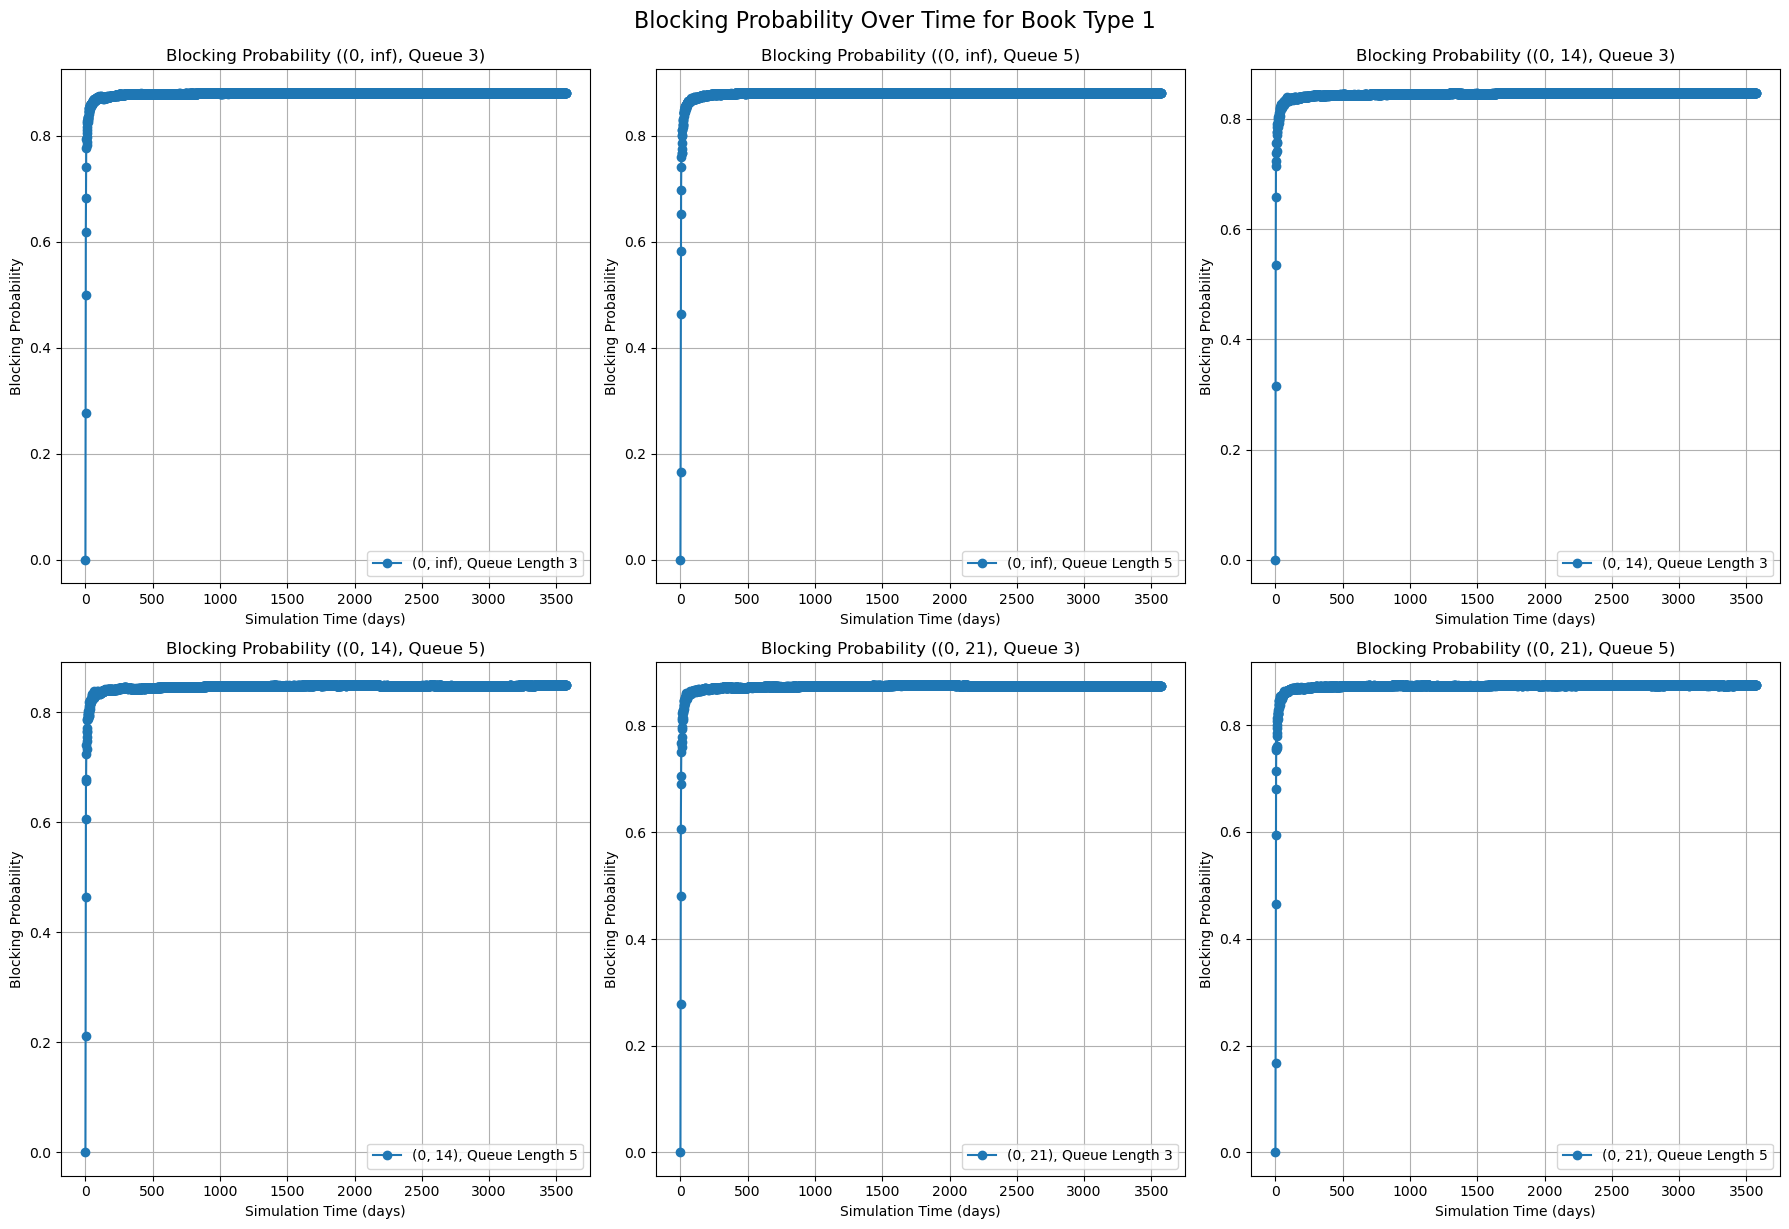

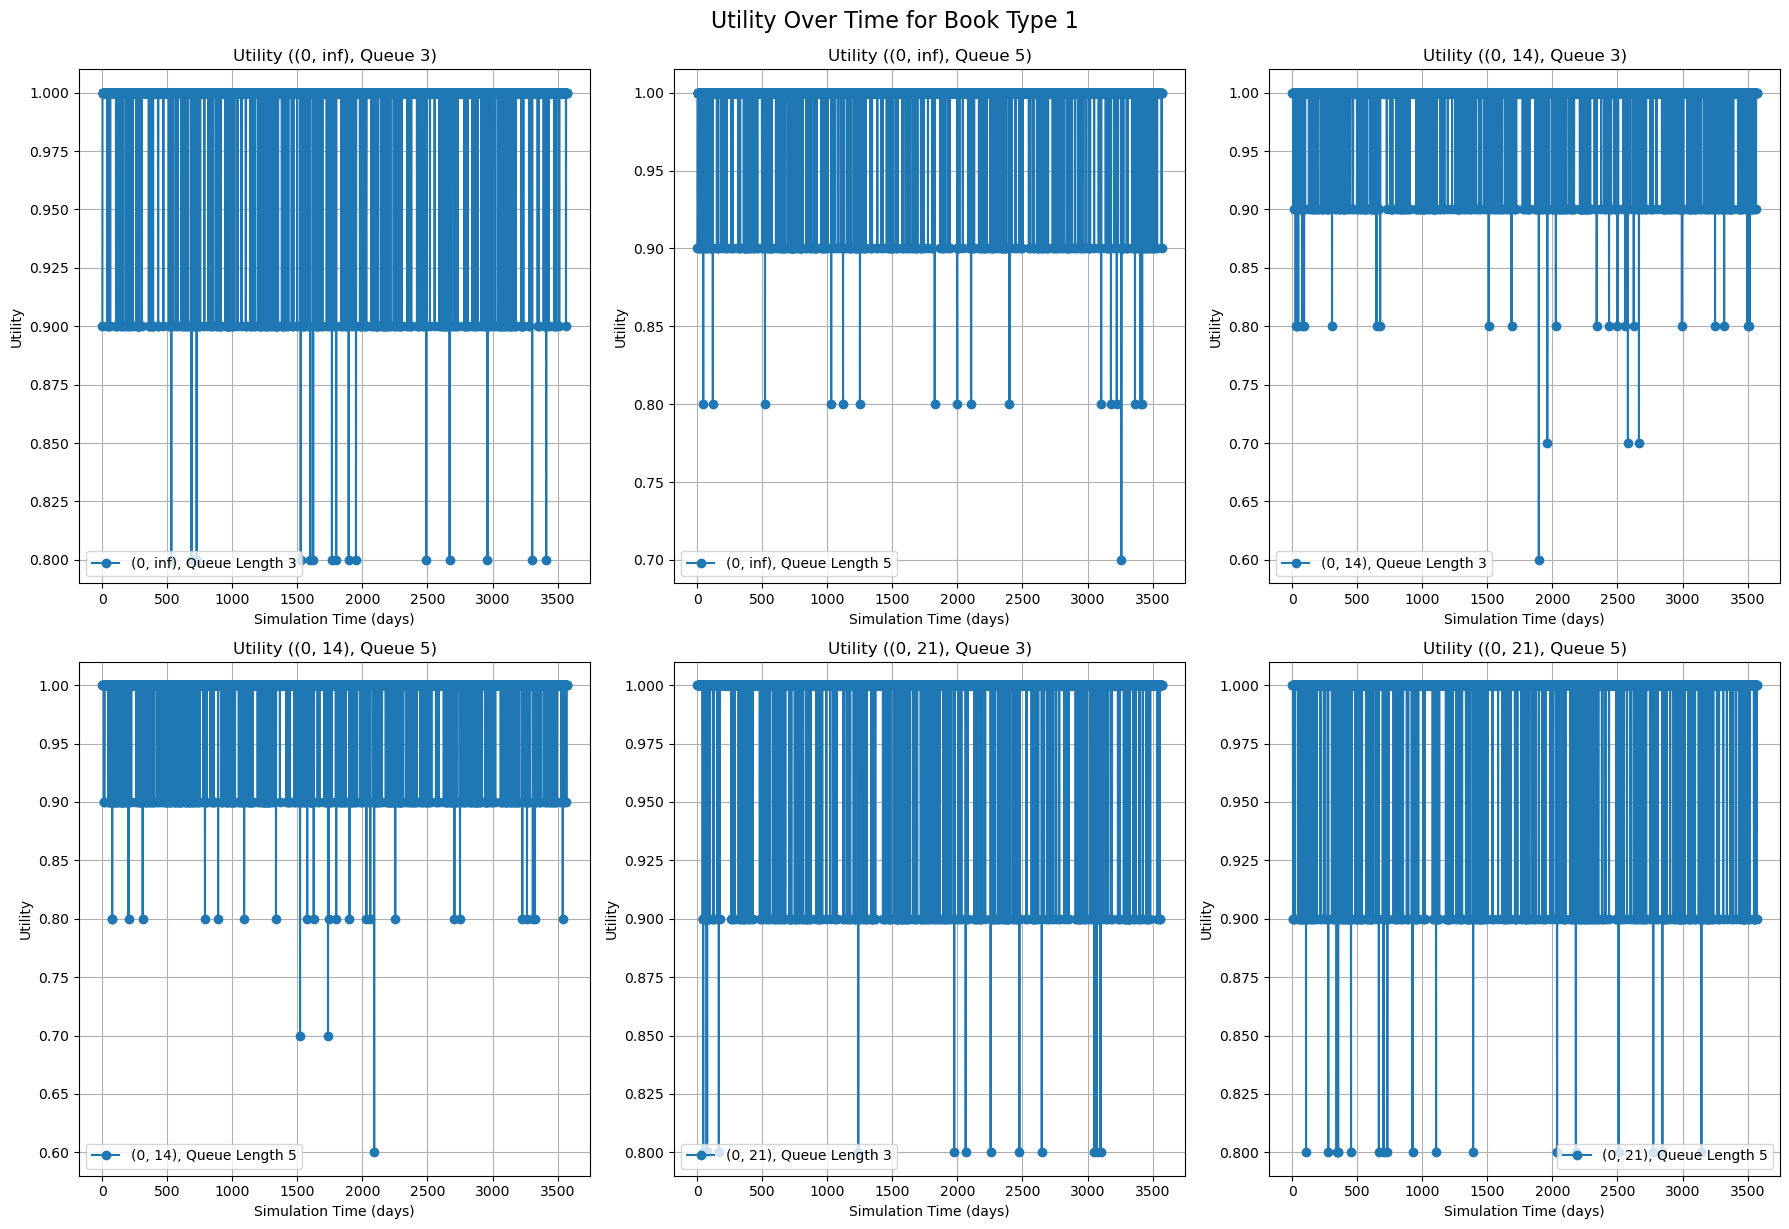

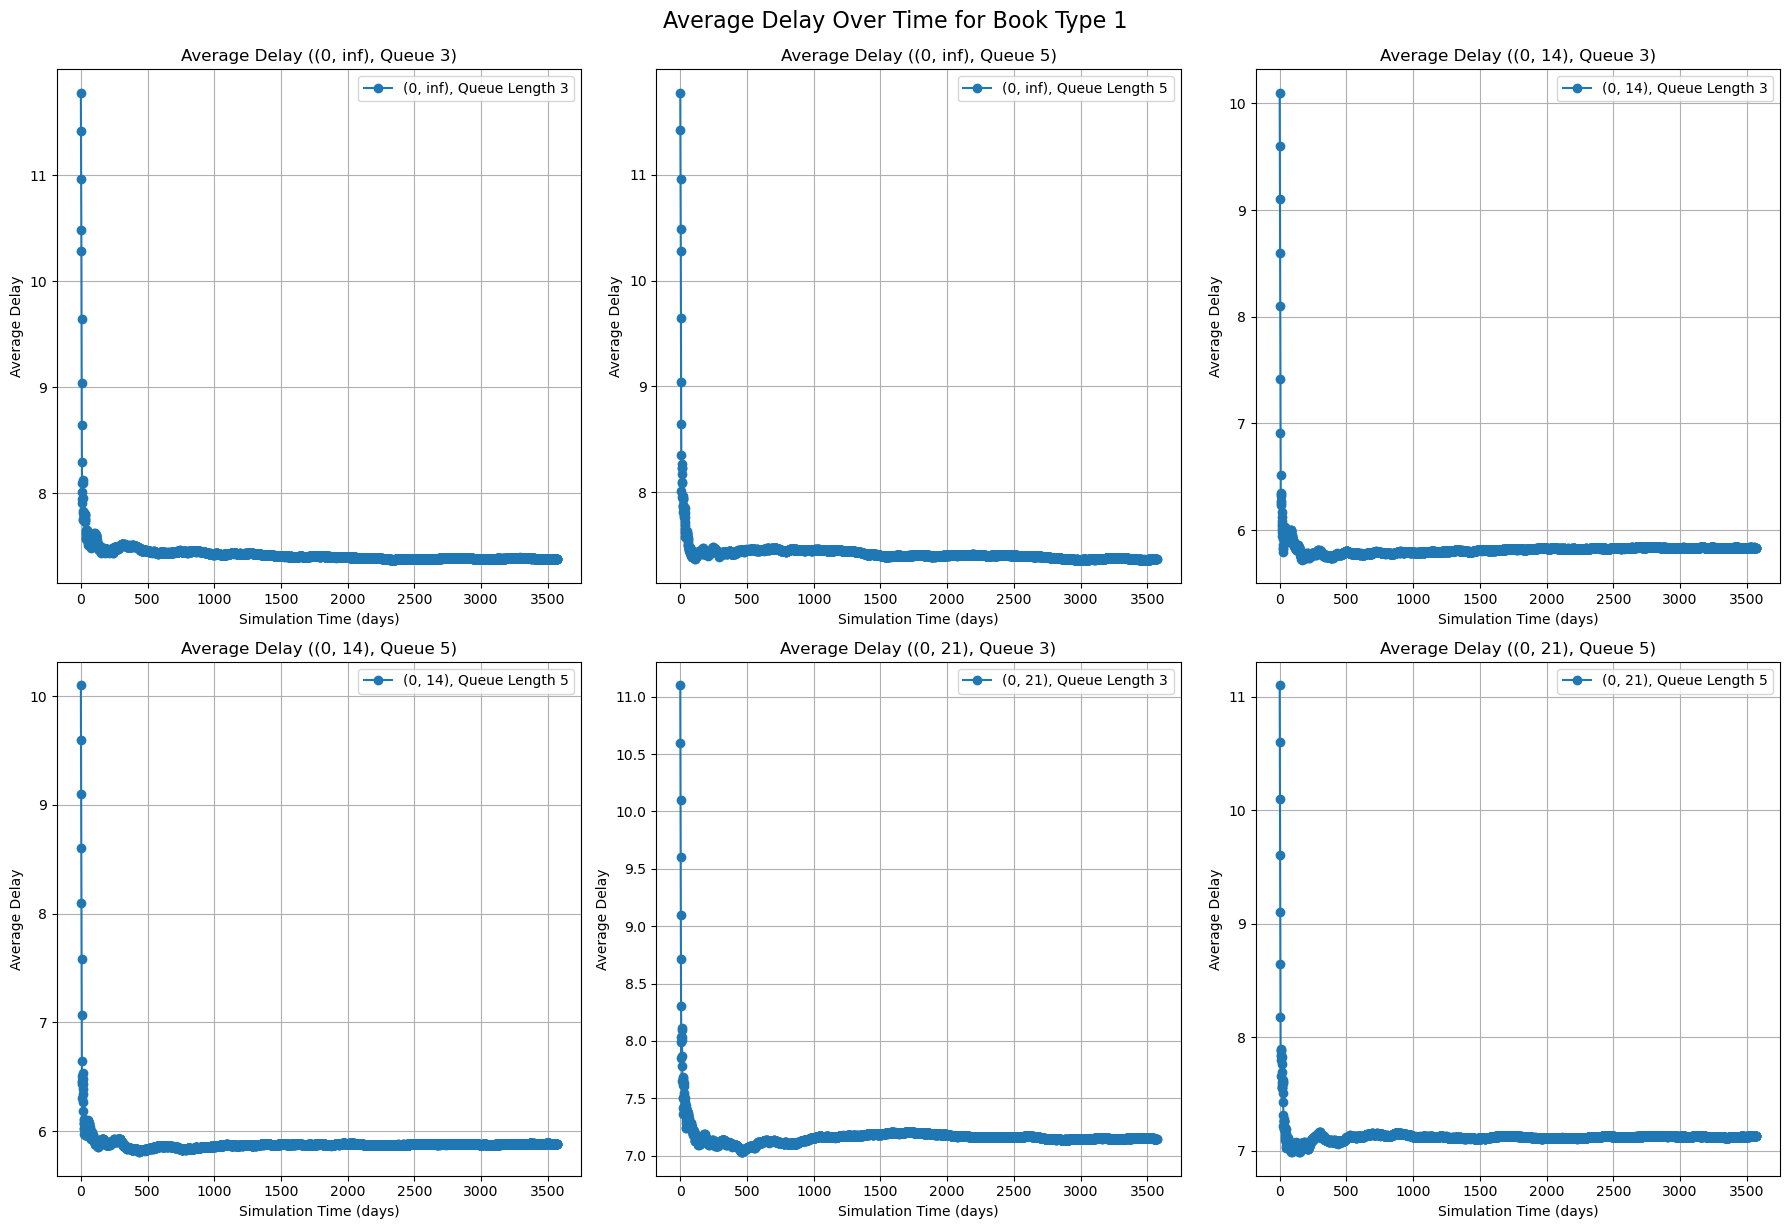

In [ ]:
# Visualization Function
def visualize_results(results_df, book_type):
    metrics = ["Blocking Probability", "Utility", "Average Delay"]

    for metric in metrics:
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
        axes = axes.flatten()
        for i, (_, row) in enumerate(results_df.iterrows()):
            ax = axes[i]
            ax.plot(
                range(len(row[metric])),
                row[metric],
                marker="o",
                label=f"{row['Return Range']}, Queue Length {row['Queue Length']}"
            )
            ax.set_title(f"{metric} ({row['Return Range']}, Queue {row['Queue Length']})")
            ax.set_xlabel("Simulation Time (days)")
            ax.set_ylabel(metric)
            ax.legend()
            ax.grid()
        plt.tight_layout()
        plt.suptitle(f"{metric} Over Time for Book Type {book_type}", y=1.02, fontsize=16)
        plt.show()

# Visualize Results
visualize_results(results_df, book_type_to_test)

In [ ]:
results = []
for metric, values in data.items():
    if "Avg" in metric:  # Only calculate for average metrics
        std_dev = np.sqrt(data["Var " + metric.split(" ")[1]])
        metric_intervals = []
        for avg, std in zip(values, std_dev):
            margin_of_error = z_score * std
            interval = (avg - margin_of_error, avg + margin_of_error)
            metric_intervals.append(interval)
        results.append((metric, metric_intervals))

results_df = pd.DataFrame({metric: intervals for metric, intervals in results})
results_df.index = [f"Scenario {i + 1}" for i in range(len(results_df))]

In [ ]:
import numpy as np
from scipy.stats import ttest_ind_from_stats
import pandas as pd

# Data for confidence intervals
confidence_intervals = {
    "Avg Blocking Probability": {
        "Scenario 1": (0.8382758714510409, 0.9189291285489592),
        "Scenario 2": (0.8352238729717171, 0.9228761270282829),
        "Scenario 3": (0.8091016707754863, 0.883786322245136),
        "Scenario 4": (0.8048909135732578, 0.8863650864267423),
        "Scenario 5": (0.8322039135732577, 0.9137780864267422),
        "Scenario 6": (0.829485093725479, 0.915276906274521)
    },
    "Avg Utility": {
        "Scenario 1": (0.93041446871315863, 1.0506613123684414),
        "Scenario 2": (0.9297159246956466, 1.053600753043535),
        "Scenario 3": (0.9266765482251139, 1.050759451748862),
        "Scenario 4": (0.9175870008288703, 1.0577209981711298),
        "Scenario 5": (0.9336767298606321, 1.0489652073913398),
        "Scenario 6": (0.92889551474614952, 1.052916548285047)
    },
    "Avg Average Delay": {
        "Scenario 1": (7.121502063961123, 7.73115936308878),
        "Scenario 2": (7.1161361382903, 7.7292258383610975),
        "Scenario 3": (5.556641892327745, 6.089406107672255),
        "Scenario 4": (5.62014309106404, 6.149417689083956),
        "Scenario 5": (6.901061543258829, 7.245772456741171),
        "Scenario 6": (6.87245841182242, 7.373635888177586)
    }
}

# Function to convert confidence intervals to mean and standard deviation
def confidence_interval_to_stats(conf_interval):
    lower, upper = conf_interval
    mean = (lower + upper) / 2
    std_dev = (upper - lower) / (2 * 1.96)  # 95% CI
    return mean, std_dev

# Determine the best scenario for each metric
def find_best_scenario(confidence_intervals):
    best_scenarios = {}

    for metric, scenarios in confidence_intervals.items():
        best_scenario = None
        best_value = None

        for scenario, conf_interval in scenarios.items():
            mean, _ = confidence_interval_to_stats(conf_interval)

            if metric == "Avg Blocking Probability" or metric == "Avg Average Delay":
                # Lower is better for these metrics
                if best_value is None or mean < best_value:
                    best_value = mean
                    best_scenario = scenario
            elif metric == "Avg Utility":
                # Higher is better for this metric
                if best_value is None or mean > best_value:
                    best_value = mean
                    best_scenario = scenario

        best_scenarios[metric] = (best_scenario, best_value)

    return best_scenarios

# Perform pairwise hypothesis testing
def perform_pairwise_tests(metric_data, alpha=0.05):
    scenarios = list(metric_data.keys())
    results = []

    for i in range(len(scenarios)):
        for j in range(i + 1, len(scenarios)):
            scenario1, scenario2 = scenarios[i], scenarios[j]
            mean1, std1 = confidence_interval_to_stats(metric_data[scenario1])
            mean2, std2 = confidence_interval_to_stats(metric_data[scenario2])

            t_stat, p_value = ttest_ind_from_stats(
                mean1, std1, 30,  # Assuming 30 samples per scenario
                mean2, std2, 30
            )

            results.append({
                "Scenario 1": scenario1,
                "Scenario 2": scenario2,
                "t_stat": t_stat,
                "p_value": p_value,
                "Significant": p_value < alpha
            })

    return results

# Perform hypothesis testing for all metrics
all_results = {}
for metric, data in confidence_intervals.items():
    all_results[metric] = perform_pairwise_tests(data)

# Find the best scenario for each metric
best_scenarios = find_best_scenario(confidence_intervals)

# Print the results for each metric
for metric, results in all_results.items():
    print(f"\nPairwise T-Test Results for {metric}:")
    for result in results:
        print(f"{result['Scenario 1']} vs {result['Scenario 2']}: ")
        print(f"    t_stat = {result['t_stat']:.4f}, p_value = {result['p_value']:.4e}, Significant = {result['Significant']}")

# Print the best scenarios
print("\nBest Scenarios:")
for metric, (scenario, value) in best_scenarios.items():
    print(f"{metric}: Best Scenario = {scenario}, Value = {value:.4f}")
